<a href="https://colab.research.google.com/github/ichelmichelll/VGG19ModelforPneumonia/blob/main/VGG19_NEWMODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

# IMPORTING LIBRARIES

In [ ]:
from google.colab import files
import shutil
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.optimizers import Adam

# LOAD DATA

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"messyacarment","key":"046aba1afffee276c187075b5128d298"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
if 'kaggle.json' in os.listdir():
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
else:
    print('Error: kaggle.json not found in the uploaded files.')

In [ ]:
if os.path.exists('/root/.kaggle/kaggle.json'):
    print('kaggle.json is already in /root/.kaggle/')
else:
    print('kaggle.json is not found in /root/.kaggle/')

kaggle.json is already in /root/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:15<00:00, 190MB/s]
100% 2.29G/2.29G [00:15<00:00, 156MB/s]


In [ ]:
!sudo apt install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!unzip -q "chest-xray-pneumonia.zip"

In [ ]:
cd /content/chest_xray

/content/chest_xray


In [ ]:
!pwd

/content/chest_xray


# DATA PRE-PROCESSING

In [ ]:
image_shape =(224,224,3)

In [ ]:
# ImageDataGenerator untuk preprocessing data
train_datagen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=.1,
                               height_shift_range=.1,
                               shear_range=.1,
                               zoom_range= .1,
                               horizontal_flip=True,
                              fill_mode='nearest',
                               rescale=1./255 )

# Generator data untuk training
training_set = train_datagen.flow_from_directory(
        './train',
        target_size =image_shape[:2],
        batch_size = 32,
        class_mode='binary')

Found 5216 images belonging to 2 classes.


In [ ]:
# Generator data untuk testing
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        './test',
        target_size =image_shape[:2],
        batch_size = 32,
        class_mode='binary',
        shuffle=False)

Found 624 images belonging to 2 classes.


In [ ]:
train_datagen.flow_from_directory('./train')

Found 5216 images belonging to 2 classes.


In [ ]:
test_datagen.flow_from_directory('./test')

Found 624 images belonging to 2 classes.


# TRAINING & TESTING DATA USING VGG-19

In [ ]:
Model
# Load the VGG19 model, without the top layers, with pre-trained ImageNet weights
vgg = VGG19(input_shape=image_shape, weights='imagenet', include_top=False)
# Freeze the layers of VGG19
for layer in vgg.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# Create the model
modelvgg = Model(inputs=vgg.input, outputs=prediction)# Model
# Load the VGG19 model, without the top layers, with pre-trained ImageNet weights
vgg = VGG19(input_shape=image_shape, weights='imagenet', include_top=False)
# Freeze the layers of VGG19
for layer in vgg.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# Create the model
modelvgg = Model(inputs=vgg.input, outputs=prediction)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
modelvgg.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy', metrics=['accuracy'])modelvgg.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [ ]:
history=modelvgg.fit(training_set, epochs=20,
                     validation_data = test_set,
                     callbacks=[early_stop])

Epoch 1/20
163/163 [==============================] - 127s 716ms/step - loss: 0.2323 - accuracy: 0.9032 - val_loss: 0.2658 - val_accuracy: 0.8990
Epoch 2/20
163/163 [==============================] - 111s 680ms/step - loss: 0.1389 - accuracy: 0.9465 - val_loss: 0.3072 - val_accuracy: 0.8974
Epoch 3/20
163/163 [==============================] - 116s 712ms/step - loss: 0.1190 - accuracy: 0.9565 - val_loss: 0.2320 - val_accuracy: 0.9135
Epoch 4/20
163/163 [==============================] - 110s 677ms/step - loss: 0.1193 - accuracy: 0.9540 - val_loss: 0.3597 - val_accuracy: 0.8814
Epoch 5/20
163/163 [==============================] - 113s 693ms/step - loss: 0.1077 - accuracy: 0.9578 - val_loss: 0.4600 - val_accuracy: 0.8494
Epoch 6/20
163/163 [==============================] - 113s 693ms/step - loss: 0.1014 - accuracy: 0.9580 - val_loss: 0.5952 - val_accuracy: 0.8189
Epoch 6: early stopping


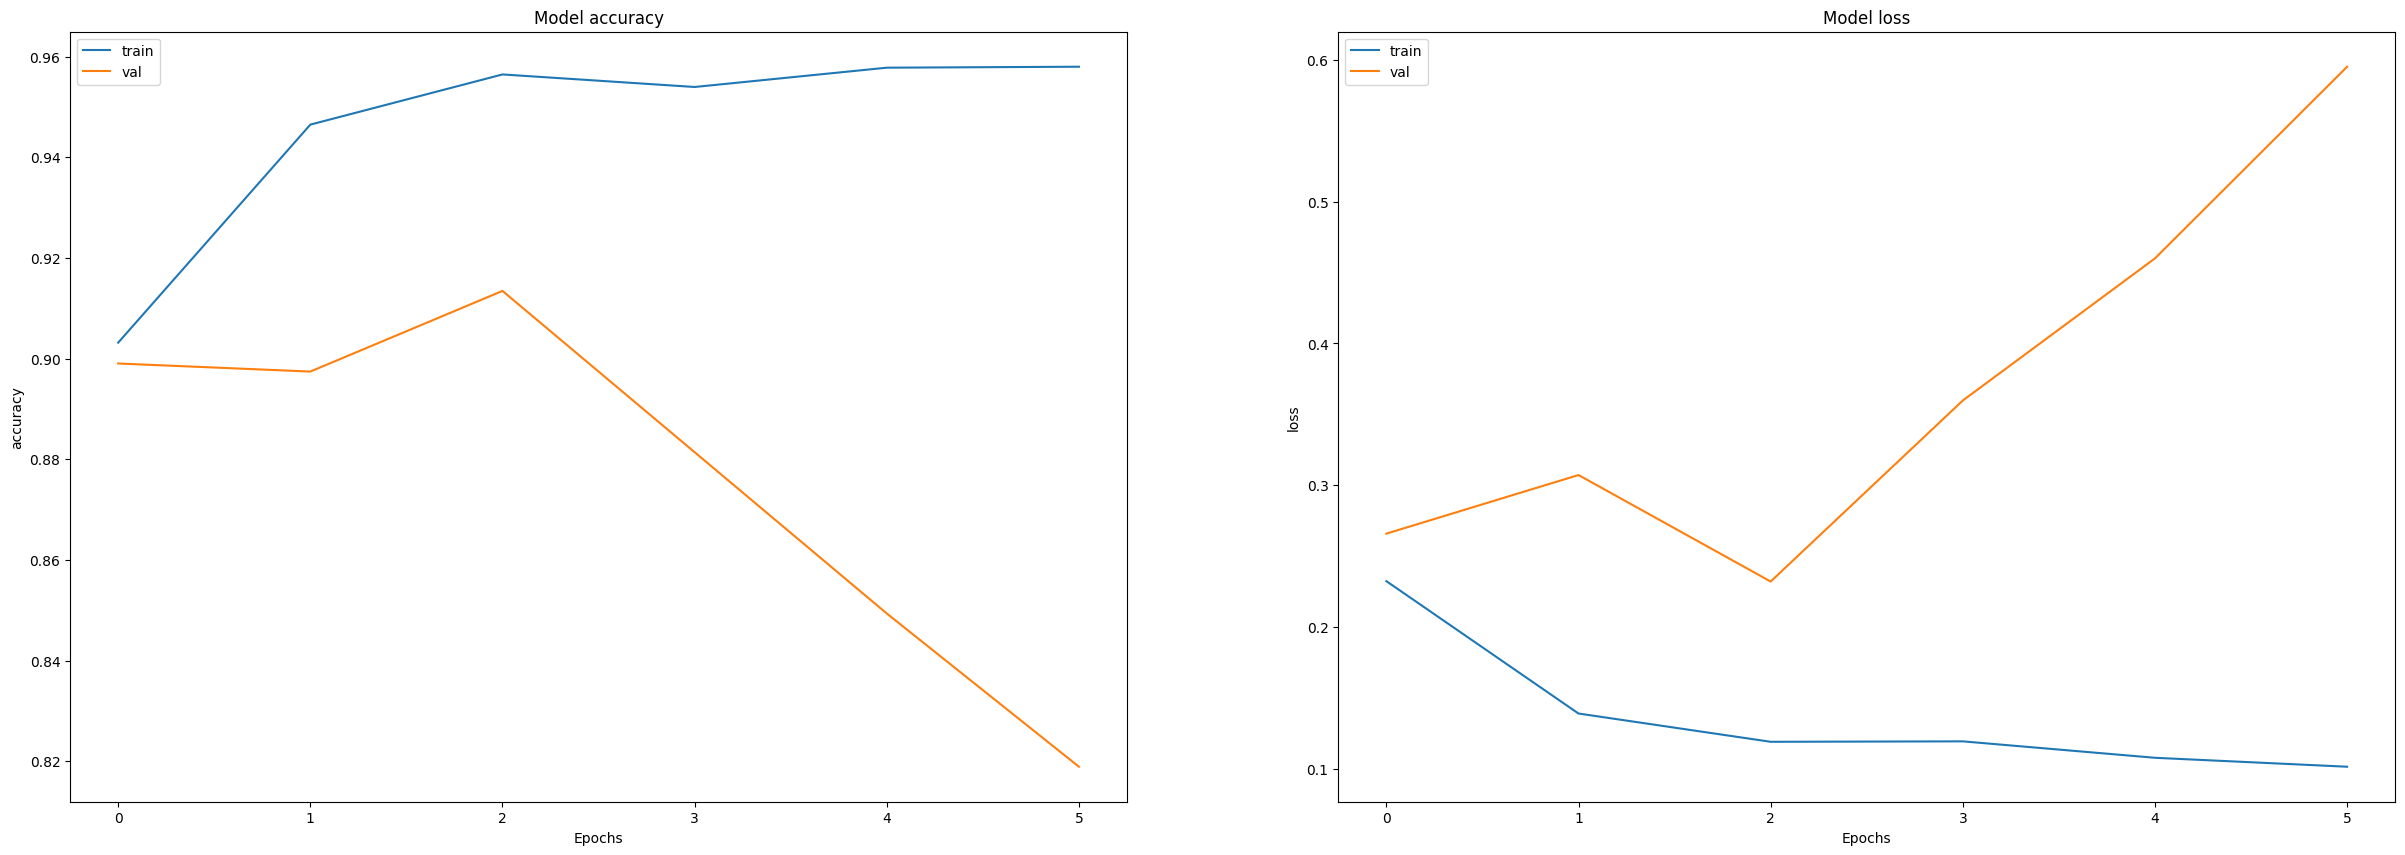

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# EVALUATION

In [ ]:
# Evaluate the model
modelvgg.evaluate(test_set, verbose=0)

[0.23203106224536896, 0.9134615659713745]

In [ ]:
# Result
y_pred = modelvgg.predict(test_set)
y_pred = y_pred.round()
y_true = test_set.classes
print(classification_report(y_true,y_pred))

20/20 [==============================] - 7s 305ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       234
           1       0.93      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
# Result using Jaccard Similarity
y_pred = modelvgg.predict(test_set)
y_pred = y_pred.round()

y_true=test_set.classes


mlb = MultiLabelBinarizer()
y_true_bin = mlb.fit_transform([[label] for label in y_true])
y_pred_bin = mlb.transform(y_pred)

accuracy = jaccard_score(y_true_bin, y_pred_bin, average='samples')
print("Accuracy (Jaccard Similarity): ", accuracy)
print(classification_report(y_true_bin, y_pred_bin))


20/20 [==============================] - 11s 454ms/step
Accuracy (Jaccard Similarity):  0.9134615384615384
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       234
           1       0.93      0.93      0.93       390

   micro avg       0.91      0.91      0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624
 samples avg       0.91      0.91      0.91       624



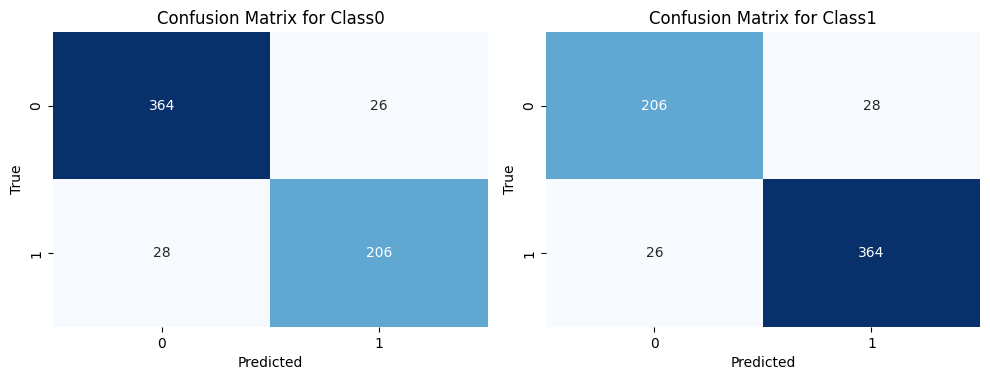

In [ ]:
# Confusion Matrix
cnf_matrix = multilabel_confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
for i in range(len(mlb.classes_)):
  plt.subplot(2,2, i+1)
  sns.heatmap(cnf_matrix[i], annot=True, cmap="Blues", fmt='g', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix for Class{mlb.classes_[i]}')
plt.tight_layout()
plt.show()

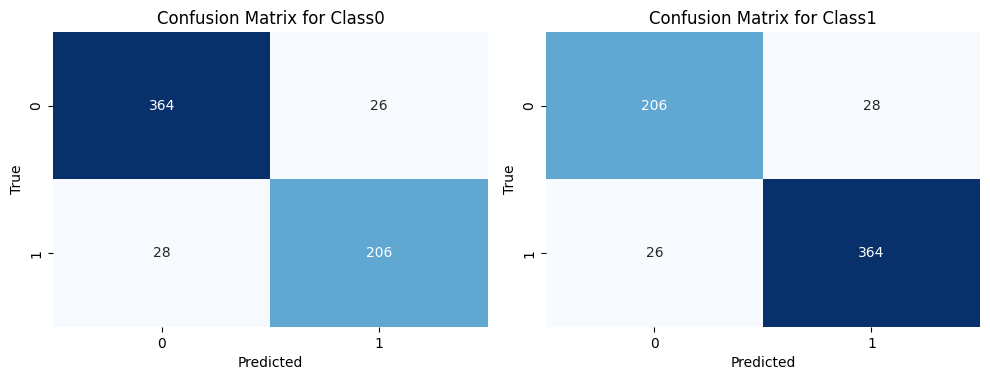

In [ ]:
# Confusion Matrix based on Result using Jaccard Similarity
cnf_matrix = multilabel_confusion_matrix(y_true_bin, y_pred_bin)

plt.figure(figsize=(10,7))
for i in range(len(mlb.classes_)):
  plt.subplot(2,2, i+1)
  sns.heatmap(cnf_matrix[i], annot=True, cmap="Blues", fmt='g', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix for Class{mlb.classes_[i]}')
plt.tight_layout()
plt.show()